In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import importlib
import numpy as np
import seaborn as sb 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import math
import optuna
import seaborn as sns

from datetime import datetime, timedelta
from numpy import linalg as LA
from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error
from config import settings

# Data

In [2]:
import data_FX
importlib.reload(data_FX)
from data_FX import SQLconnect, SQLRepository, DataAnalysis, OptimizeDensity

## Data initiating

In [3]:
# Initiate the connection with MySQL

sqlconn = SQLconnect()
connection = sqlconn.get_sql_connection(dbname=settings.dbname)
cursor = connection.cursor()
repo = SQLRepository(connection=connection)

connection is ready


In [4]:
# Data Input

# Tickers list
ticker = ['audusd', 'eurusd', 'gbpusd', 'nzdusd', 'usdcad', 'usdchf', 'usdjpy', 'usdsgd', 'usdmxn', 'usdnok', 'usdsek']
# Database name
dbname = settings.dbname
# Extracted column
data_column = 'close'
axis = 0
# Date and time ---> returns data from 2022-01-02 00:00:00 to 2022-12-31 00:00:00
from_date = '2022.01.02'
to_date = '2022.12.31'

# Load data into dataframe
df = repo.read_table(from_date, to_date, ticker, dbname, data_column, axis)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374312 entries, 2022-01-02 17:00:00 to 2022-12-30 16:58:00
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   audusd  371495 non-null  float64
 1   eurusd  372805 non-null  float64
 2   gbpusd  372434 non-null  float64
 3   nzdusd  370359 non-null  float64
 4   usdcad  371340 non-null  float64
 5   usdchf  369348 non-null  float64
 6   usdjpy  372536 non-null  float64
 7   usdmxn  368574 non-null  float64
 8   usdnok  364769 non-null  float64
 9   usdsek  365525 non-null  float64
 10  usdsgd  366295 non-null  float64
dtypes: float64(11)
memory usage: 34.3 MB


pair                  audusd   eurusd   gbpusd   nzdusd   usdcad   usdchf  \
time                                                                        
2022-01-02 17:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2022-01-02 17:01:00      NaN      NaN  1.35213      NaN      NaN      NaN   
2022-01-02 17:02:00      NaN      NaN  1.35232      NaN      NaN      NaN   
2022-01-02 17:03:00      NaN  1.13690      NaN      NaN      NaN      NaN   
2022-01-02 17:04:00      NaN  1.13689  1.35233      NaN      NaN      NaN   
...                      ...      ...      ...      ...      ...      ...   
2022-12-30 16:54:00  0.68154  1.07001  1.20924  0.63495  1.35502  0.92470   
2022-12-30 16:55:00  0.68155  1.07001  1.20918  0.63507  1.35452  0.92463   
2022-12-30 16:56:00  0.68175  1.07008  1.20930  0.63514  1.35424  0.92469   
2022-12-30 16:57:00  0.68171  1.07030  1.20931  0.63497  1.35433  0.92455   
2022-12-30 16:58:00  0.68168  1.07054  1.20963  0.63508  1.35460  0.92442   

pair                  usdjpy    usdmxn   usdnok    usdsek   usdsgd  
time                                                                
2022-01-02 17:00:00  115.040       NaN  8.79419       NaN  1.34766  
2022-01-02 17:01:00  115.040       NaN      NaN       NaN      NaN  
2022-01-02 17:02:00      NaN       NaN      NaN       NaN      NaN  
2022-01-02 17:03:00      NaN       NaN      NaN       NaN      NaN  
2022-01-02 17:04:00  115.048       NaN      NaN       NaN      NaN  
...                      ...       ...      ...       ...      ...  
2022-12-30 16:54:00  131.112  19.47901  9.78298  10.42743  1.33999  
2022-12-30 16:55:00  131.101  19.48178  9.78233  10.42693  1.34006  
2022-12-30 16:56:00  131.090  19.48319  9.78840  10.42693  1.34033  
2022-12-30 16:57:00  131.090  19.48151  9.78647  10.41993  1.34034  
2022-12-30 16:58:00  131.106  19.48579  9.77834  10.39477  1.34026  

[374312 rows x 11 columns]

## Data wrangling

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374312 entries, 2022-01-02 17:00:00 to 2022-12-30 16:58:00
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   aud     371495 non-null  float64
 1   eur     372805 non-null  float64
 2   gbp     372434 non-null  float64
 3   nzd     370359 non-null  float64
 4   cad     371340 non-null  float64
 5   chf     369348 non-null  float64
 6   jpy     372536 non-null  float64
 7   mxn     368574 non-null  float64
 8   nok     364769 non-null  float64
 9   sek     365525 non-null  float64
 10  sgd     366295 non-null  float64
 11  week    374312 non-null  object 
dtypes: float64(11), object(1)
memory usage: 37.1+ MB


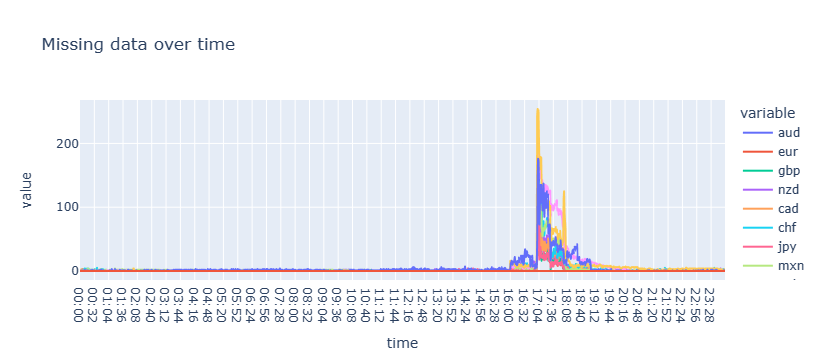

In [12]:
# Include 4 steps: update pair name, inverse rates, append 'week' column and reindex database according to week.

anal = DataAnalysis()
df_stats = anal.data_wrangle(df)

# Check the data availability
df_stats.info()

fig = px.line((pd.isna(df_stats)).groupby(df_stats.index.strftime('%H:%M')).sum(), \
             title='Missing data over time')
fig.show();

# Data analysis

## Descriptive statistics

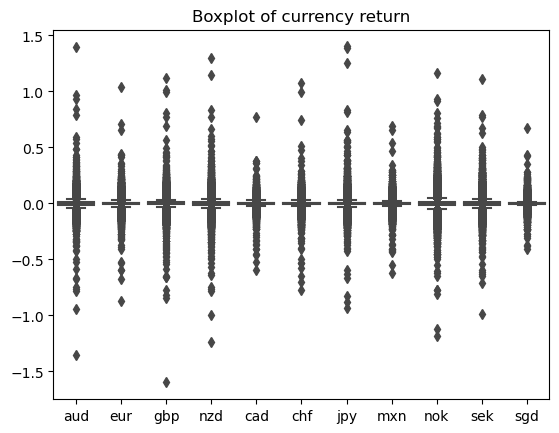

Descriptive statistics:
                  aud            eur            gbp            nzd  \
count  366263.000000  366263.000000  366263.000000  366263.000000   
mean       -0.000011      -0.000018      -0.000034      -0.000016   
std         0.023135       0.017924       0.021289       0.023220   
min        -1.355544      -0.870950      -1.599016      -1.234217   
25%        -0.010927      -0.007631      -0.008189      -0.010484   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.010858       0.007521       0.008123       0.010394   
max         1.398034       1.041447       1.116870       1.299765   

                 cad            chf            jpy            mxn  \
count  366263.000000  366263.000000  366263.000000  366263.000000   
mean       -0.000012      -0.000004      -0.000025       0.000005   
std         0.014539       0.016880       0.018508       0.018699   
min        -0.593211      -0.771508      -0.937256      -0.620112   
25%     

In [78]:
"""
Compute 1 minute return and remove data within 17:00 - 17:30 due to lacking of data.
This step simultaneously removes returns at 17:00 each Sunday, which is opening time of the week when liquidity is extremely low.
"""

# Define removal period
drop_from_time = '17:00'
drop_end_time = '17:30'

# Compute return by minute
df_g10 = anal.compute_return(df_reindex, drop_from_time, drop_end_time)

# Statistics and boxplot

ax = plt.axes()
sns.boxplot(df_g10, ax=ax)
plt.title('Boxplot of currency return')
plt.show();

print(f"Descriptive statistics:\n", df_g10.describe())


## Correlation heatmap

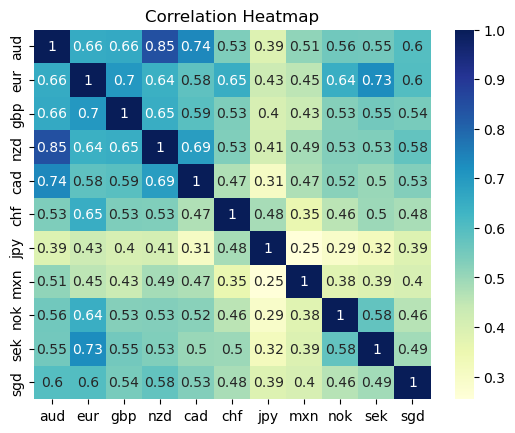

In [79]:
ax = plt.axes()
sns.heatmap(df_g10.corr(), cmap="YlGnBu", annot=True, ax = ax)
ax.set_title('Correlation Heatmap')
plt.show();

## Eigenvalues

In [80]:
# Using excess out-of-sample risk covariance to derive eigenvalues

df_eig = anal.compute_eig(df_g10)
df_eig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136190 entries, 2022-01-02 18:31:00 to 2022-12-30 16:43:00
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   1       136190 non-null  float64
 1   2       136190 non-null  float64
 2   3       136190 non-null  float64
 3   4       136190 non-null  float64
 4   5       136190 non-null  float64
 5   6       136190 non-null  float64
 6   7       136190 non-null  float64
 7   8       136190 non-null  float64
 8   9       136190 non-null  float64
 9   10      136190 non-null  float64
 10  11      136190 non-null  float64
dtypes: float64(11)
memory usage: 12.5 MB


# Eigenvalues Interpretation

## Outliers detection

In [43]:
"""
Identify outliers in eigenvalues to check whether it is a noise or signal
How to identify:
- Group eigenvalues by timestamp within a date
- Identify at what time the outliers (H:M) appeared and on which eigenvalue. 
- From recognized (H:M), locate the exact date when the outliers occured
- Find the reasons behind that
- If the outlier is explanable, consider it as signal. Otherwise it would be considered as noise and be removed to smooth the database
"""

In [43]:
# Group by 10 mins
df_eig_mean = df_eig.groupby(pd.Grouper(freq='10min')).mean()

# Group by timestamp within a date
df_eig_intraday = df_eig_mean.groupby(df_eig_mean.index.strftime('%H:%M')).mean()

# Plot eigenvalues intraday
fig = px.line(df_eig_intraday)
fig.show();

## Noise removal

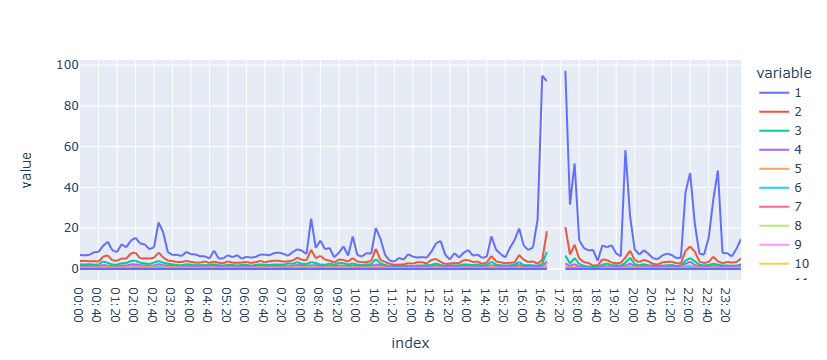

In [44]:
# Since the outlier time is 01:50, we should check all data around 01:40 to 02:00

date_eig_high = [d for d in df_eig_mean.index.strftime('%Y-%m-%d %H:%M').to_list() if ('01:50' in d)]

df_eig_mean.loc[date_eig_high,1].nlargest(n=10)

""" 
Outliers in the first eigenvalue occured in: 
[2022-12-26 01:50:00, 2022-12-26 01:52:00    
2022-12-26 01:54:00    
2022-12-26 01:55:00    
2022-12-26 01:56:00]

Outliers in the remaining eigenvalues occured in:
[2022-12-25 19:53:00
2022-12-25 19:56:00
2022-12-25 19:57:00
2022-12-25 19:58:00
2022-12-25 19:59:00]

['2022-10-31 17:34:00']
"""

# Once noise is detected, remove it from database
drop_list = \
['2022-12-26 01:50:00', '2022-12-26 01:52:00', '2022-12-26 01:54:00', '2022-12-26 01:55:00', '2022-12-26 01:56:00',\
'2022-12-25 19:53:00', '2022-12-25 19:56:00', '2022-12-25 19:57:00', '2022-12-25 19:58:00', '2022-12-25 19:59:00']

df_eig_final = df_eig.drop(drop_list)

df_eig_mean_final = df_eig_final.groupby(pd.Grouper(freq='10min')).mean()

# Group by timestamp within a date
df_eig_intraday_final = df_eig_mean_final.groupby(df_eig_mean_final.index.strftime('%H:%M')).mean()

# Plot eigenvalues intraday
fig = px.line(df_eig_intraday_final)
fig.show()

## Density function

In [71]:
# Empirical density

percent=99
opt = OptimizeDensity()

eig_hist, hist, bin_edges = opt.emp_density(df_eig_final, percent)
# eig_hist is eigenvalues dataframe used to plot the empirical histogram


In [72]:
# Find the optimal set of parameters (q_in, q_out) so that the theoretical density matches to empirical one

n_trials = 100
best_trial_number, best_trial_value, best_params = opt.optimize_params(n_trials=100, bin_edges=bin_edges, hist=hist)

print("Best trial:", best_trial_number)
print("Best accuracy:", best_trial_value)
print("Best hyperparameters:", best_params)


[I 2024-02-02 15:30:05,967] A new study created in memory with name: no-name-95481a13-f4be-46be-9b0c-5b18013ed517
[I 2024-02-02 15:30:05,967] Trial 0 finished with value: 0.05535642374758626 and parameters: {'q_in': 0.07976618951102897, 'q_out': 2.3805335208917024}. Best is trial 0 with value: 0.05535642374758626.
[I 2024-02-02 15:30:05,983] Trial 1 finished with value: 0.053361891426117906 and parameters: {'q_in': 0.13443982313573907, 'q_out': 1.7538474553802355}. Best is trial 1 with value: 0.053361891426117906.
[I 2024-02-02 15:30:05,985] Trial 2 finished with value: 0.057038067832894376 and parameters: {'q_in': 0.10797204749208439, 'q_out': 3.7685477812442607}. Best is trial 1 with value: 0.053361891426117906.
[I 2024-02-02 15:30:05,992] Trial 3 finished with value: 0.05690544010306013 and parameters: {'q_in': 0.02108408212665631, 'q_out': 3.611963516022826}. Best is trial 1 with value: 0.053361891426117906.
[I 2024-02-02 15:30:05,992] Trial 4 finished with value: 0.055381794495976

Best trial: 57
Best accuracy: 0.0531281678692867
Best hyperparameters: {'q_in': 0.778758724411949, 'q_out': 1.4115490963282913}


## Figures illustration

### Max eigenvalues

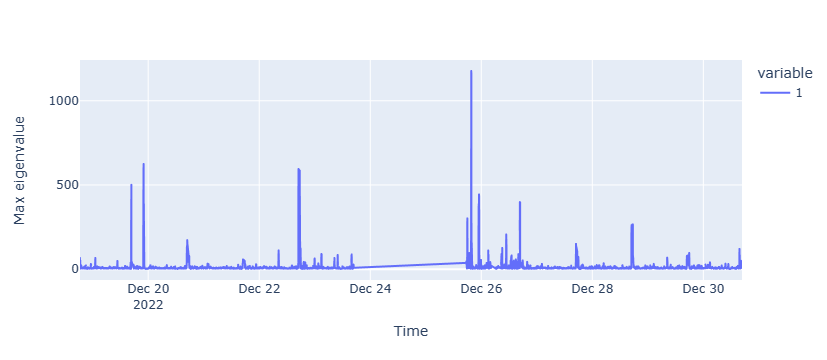

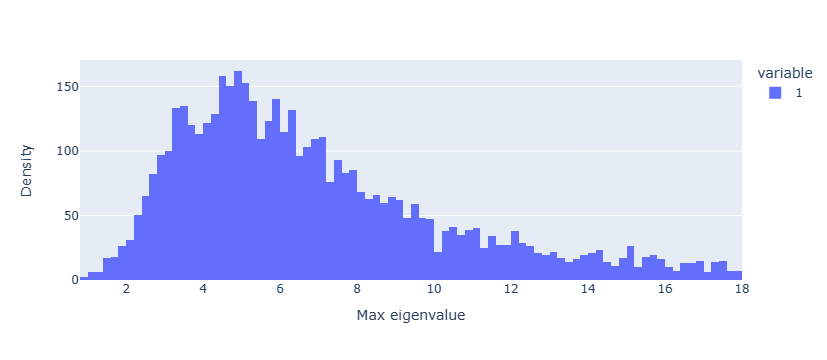

In [73]:
# Plot max eigenvalue line and histogram
fig = px.line(df_eig_final[1])
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Max eigenvalue"), 
fig.show();

eig_max = df_eig_final[1]
cond_eig_max = eig_max <= np.quantile(eig_max, q=0.9)
fig = px.histogram(eig_max[cond_eig_max], nbins=100)
fig.update_layout(
    xaxis_title="Max eigenvalue",
    yaxis_title="Density")
fig.show();

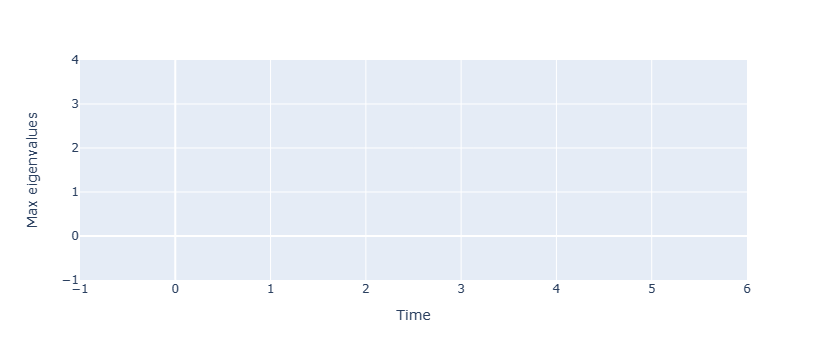

In [51]:
# Plot max eigenvalues in specified period of time

fig = px.line(df_eig_final.loc['2022-10-01 00:00': '2022-11-08 00:00',1])
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Max eigenvalues")
fig.show();


### Empirical density

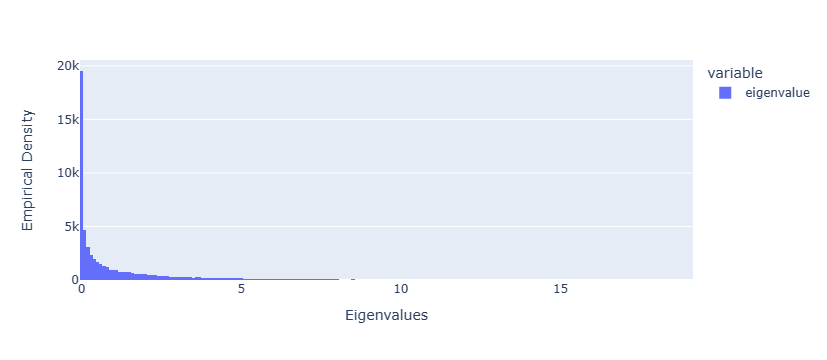

In [123]:
fig = px.histogram(eig_hist, nbins=200)
fig.update_layout(
    xaxis_title="Eigenvalues",
    yaxis_title="Empirical Density")
fig.show()


In [129]:
best_params

{'q_in': 0.7970356494985299, 'q_out': 1.426657561811616}

### Theoretical density

max lambda: 101.26089788753353, min lambda: 0.04363928172380325


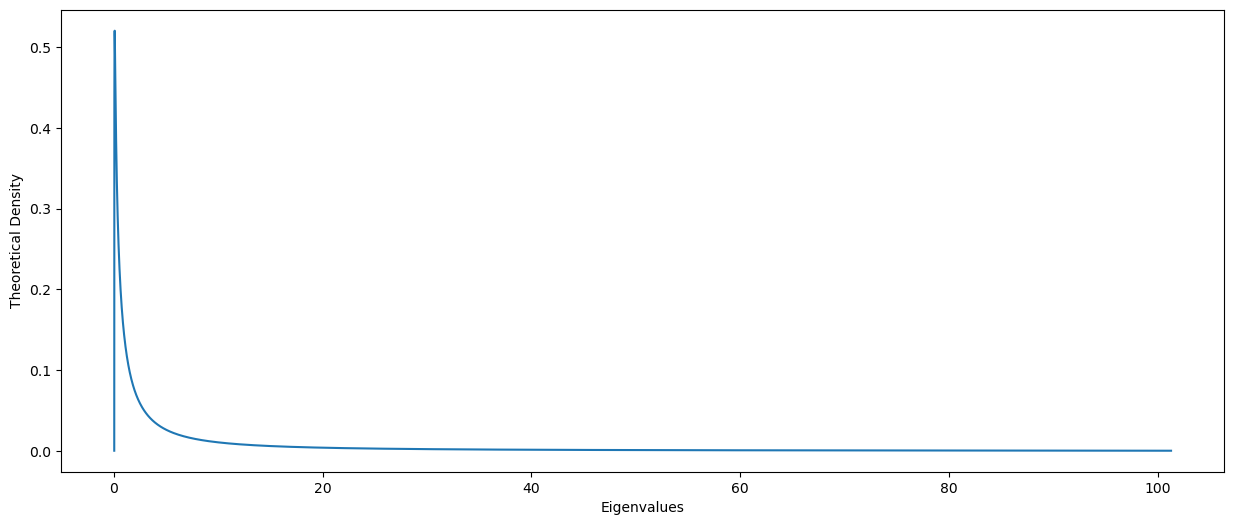

In [131]:
q_in = best_params['q_in']
q_out = best_params['q_out']

fig, ax = plt.subplots(figsize=(15,6))

p_lambda, lambda_min, lambda_max, lambda_array = opt.rho(q_in, q_out, bin_edges=bin_edges)         

smooth_lambda_array = np.exp(np.linspace(np.log(lambda_min), np.log(lambda_max), 500))
smooth_p_lambda, _, _, _ = opt.rho(q_in, q_out, bin_edges=bin_edges, lambda_array=smooth_lambda_array) 

ax.plot(smooth_lambda_array, smooth_p_lambda)

plt.xlabel('Eigenvalues')
plt.ylabel('Theoretical Density')

print(f'max lambda: {lambda_max}, min lambda: {lambda_min}')

### Comparison

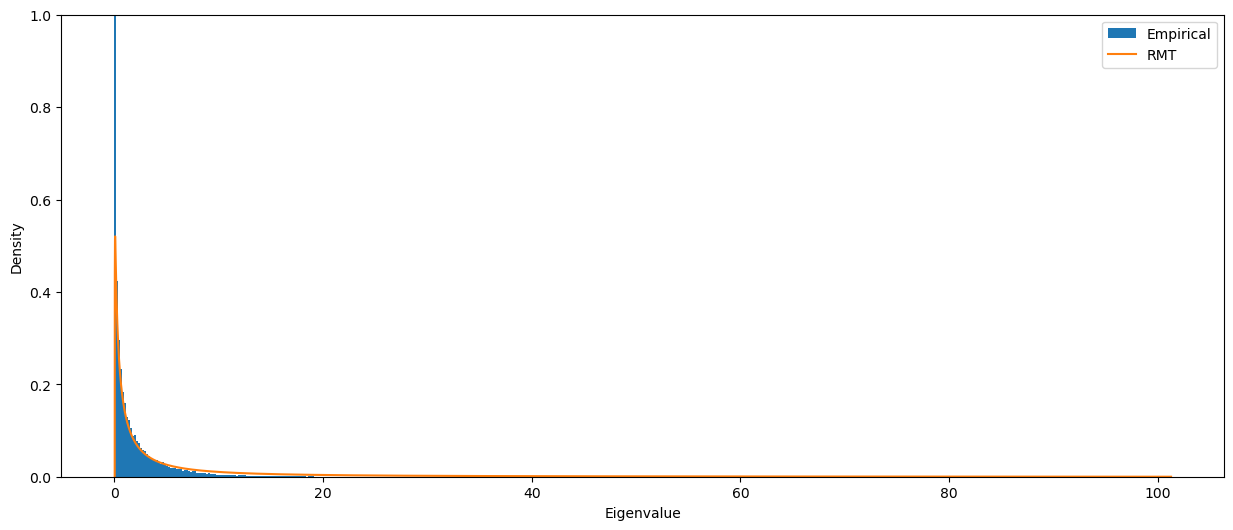

In [132]:
# Compare empirical theoretical density

fig, ax = plt.subplots(figsize=(15,6))
ax.hist(eig_hist, bins = 100, density=True, label = 'Empirical');
ax.plot(smooth_lambda_array, smooth_p_lambda, label = 'RMT');
ax.set_ylim((0,1))
ax.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Density');
